100%|██████████| 169M/169M [00:05<00:00, 31.3MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data

=== IID Sharding ===
Plot saved as: IID_Label_Distribution.pdf


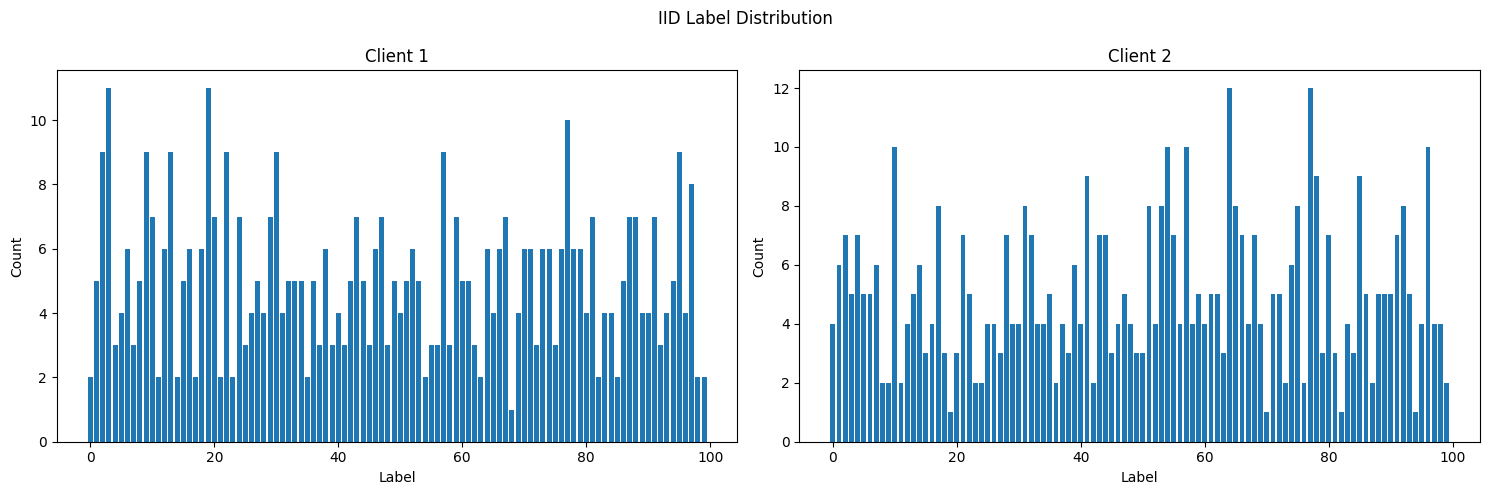

IID Sharding completed. Number of client: 100

=== Non-IID Sharding ===


Creating Non-IID Shards: 100%|██████████| 100/100 [00:00<00:00, 48607.07it/s]


Plot saved as: Non-IID_Label_Distribution.pdf


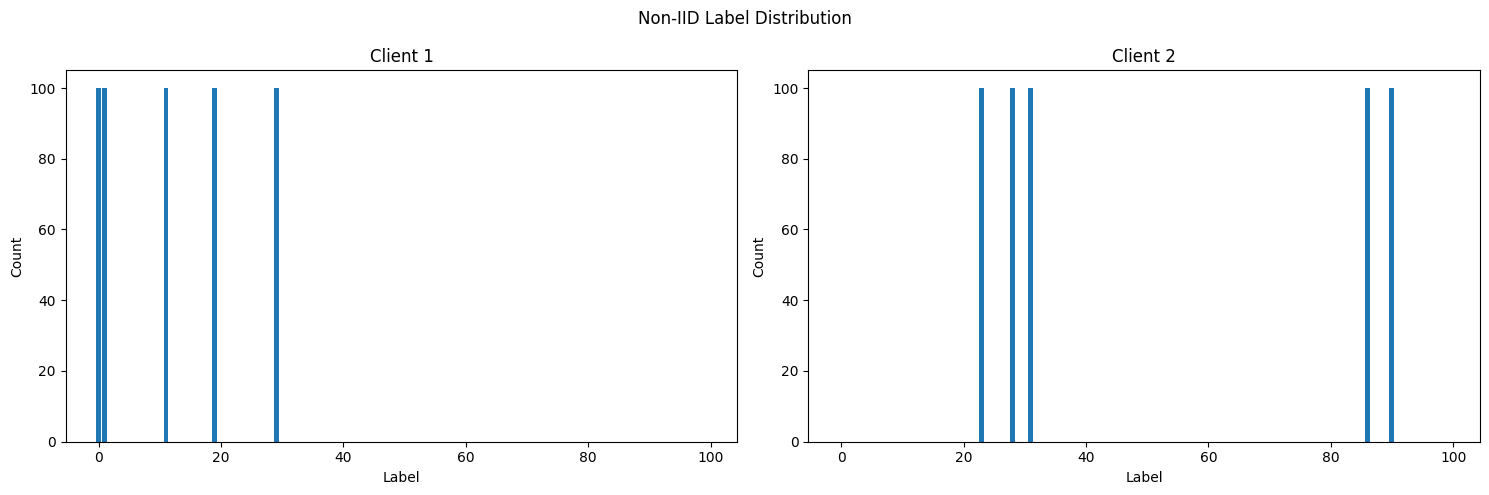

Non-IID Sharding completed. Number of client: 100


In [1]:
import torch
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import datasets, transforms
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

class DatasetSharder:
    def __init__(self, config, trainset):
        self.num_clients = config.get('K')
        self.shard_type = config.get('shard_type')
        self.num_labels = config.get('Nc', None)
        self.dataset = trainset
        self._validate_configuration()

    def _validate_configuration(self):
        dataset_size = len(self.dataset)
        total_classes = len(set([label for _, label in self.dataset]))

        if self.num_clients > dataset_size:
            raise ValueError(f"Number of clients ({self.num_clients}) exceeds dataset size ({dataset_size}).")

        if self.shard_type == 'non_iid':
            if self.num_labels is None:
                raise ValueError("Number of labels per client ('Nc') must be specified for Non-IID sharding.")
            if self.num_labels > total_classes:
                raise ValueError(f"Number of labels per client ({self.num_labels}) "
                                 f"exceeds total number of classes ({total_classes}).")

    def create_iid_shards(self):
        dataset_size = len(self.dataset)
        samples_per_client = dataset_size // self.num_clients

        lengths = [samples_per_client] * self.num_clients
        remainder = dataset_size - samples_per_client * self.num_clients
        for i in range(remainder):
            lengths[i] += 1

        return random_split(self.dataset, lengths)

    def create_non_iid_shards(self):
        # Step 1: Group dataset indices by label
        label_to_indices = defaultdict(list)
        for idx, (_, label) in enumerate(self.dataset):
            label_to_indices[label].append(idx)

        # Step 2: Shuffle the indices for each label
        for label in label_to_indices:
            shuffle(label_to_indices[label])

        # Step 3: Initialize shards
        shards = [[] for _ in range(self.num_clients)]

        # Step 4: Calculate samples per client
        total_samples = len(self.dataset)
        samples_per_client = total_samples // self.num_clients

        # Step 5: Prepare list of all labels
        all_labels = list(label_to_indices.keys())

        # Create shards
        for client_id in tqdm(range(self.num_clients), desc="Creating Non-IID Shards"):
            start_label_idx = client_id * self.num_labels
            end_label_idx = (client_id + 1) * self.num_labels
            client_labels = all_labels[start_label_idx:end_label_idx]

            client_indices = []

            for label in client_labels:
                indices = label_to_indices[label]
                num_samples_per_label = samples_per_client // self.num_labels
                client_indices.extend(indices[:num_samples_per_label])
                label_to_indices[label] = indices[num_samples_per_label:]

            client_indices = client_indices[:samples_per_client]
            shards[client_id] = client_indices

        return [Subset(self.dataset, indices) for indices in shards]

    def shard_dataset(self):
        if self.shard_type == 'iid':
            return self.create_iid_shards()
        elif self.shard_type == 'non_iid':
            return self.create_non_iid_shards()
        else:
            raise ValueError(f"Unsupported shard_type: {self.shard_type}")

def load_cifar100():
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
    ])

    trainset = datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )
    return trainset

def plot_label_distribution(client_datasets, num_classes=100, title="Label Distribution", max_clients_to_plot=2):
    num_clients_to_plot = min(len(client_datasets), max_clients_to_plot)

    client_labels = []
    for dataset in client_datasets[:num_clients_to_plot]:
        labels = [label for _, label in dataset]
        client_labels.append(labels)

    label_counts = []
    for labels in client_labels:
        counts = [labels.count(i) for i in range(num_classes)]
        label_counts.append(counts)

    # Create a figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for i in range(num_clients_to_plot):
        axes[i].bar(range(num_classes), label_counts[i])
        axes[i].set_title(f'Client {i+1}')
        axes[i].set_xlabel('Label')
        axes[i].set_ylabel('Count')

    plt.suptitle(title)
    plt.tight_layout()

    # Save the plots
    save_path = f"{title.replace(' ', '_')}.pdf"  # Save as PDF for LaTeX
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"Plot saved as: {save_path}")

    plt.show()

def main():
    # Load the CIFAR-100 training dataset
    trainset = load_cifar100()

    # Create configurations for both Non-IID and IID
    configs = {
        'iid': {
            'K': 100,
            'shard_type': 'iid'
        },
        'non_iid': {
            'K': 100,
            'shard_type': 'non_iid',
            'Nc': 5
        }
    }

    # IID Sharding
    print("\n=== IID Sharding ===")
    iid_sharder = DatasetSharder(configs['iid'], trainset)
    iid_client_datasets = iid_sharder.shard_dataset()
    plot_label_distribution(iid_client_datasets, title="IID Label Distribution")
    print(f"IID Sharding completed. Number of client: {len(iid_client_datasets)}\n")

    # Non-IID Sharding
    print("=== Non-IID Sharding ===")
    non_iid_sharder = DatasetSharder(configs['non_iid'], trainset)
    non_iid_client_datasets = non_iid_sharder.shard_dataset()
    plot_label_distribution(non_iid_client_datasets, title="Non-IID Label Distribution")
    print(f"Non-IID Sharding completed. Number of client: {len(non_iid_client_datasets)}")

if __name__ == "__main__":
    main()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import copy
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from datetime import datetime
#from dataset_sharder import DatasetSharder


# =====================
# Parameters
# =====================

K = 100              # Total number of clients
C = 0.1              # Fraction of clients selected each round
N_C = max(1, int(C*K))  # Number of selected clients each round
N = 1000             # Total number of communication rounds
J = 4                # Number of local epochs
lr = 0.01             # Learning rate
B = 64               # Batch size for client training
test_freq = 10       # Frequency of evaluation on the test set

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:

# =====================
# Data Loading and Preprocessing
# =====================

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409),
                         (0.2673, 0.2564, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409),
                         (0.2673, 0.2564, 0.2761))
])

# Load datasets
trainset = datasets.CIFAR100(root='./data', train=True,
                             download=True, transform=transform_train)
testset = datasets.CIFAR100(root='./data', train=False,
                            download=True, transform=transform_test)


Files already downloaded and verified
Files already downloaded and verified


In [4]:

# =====================
# Data Sharding
# =====================
# Shard dataset among clients using IID sharding
data_config = {
    'K': K,
    'shard_type': 'iid'
}

sharder = DatasetSharder(data_config, trainset)
client_datasets = sharder.shard_dataset()

# Create test data loader
test_loader = DataLoader(testset, batch_size=B, shuffle=False, num_workers=2)


In [5]:

# =====================
# EnhancedLeNet Model Definition
# =====================

class EnhancedLeNet(nn.Module):
    def __init__(self):
        super(EnhancedLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 384)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(384, 192)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [6]:

# =====================
# Federated Learning Implementation
# =====================

class FedAvg:
    def __init__(self, config, model, client_datasets, test_loader):
        self.config = config
        self.global_model = model
        self.client_datasets = client_datasets
        self.test_loader = test_loader
        self.device = device
        self.global_model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.num_clients = config['num_clients']

    def client_update(self, client_model, optimizer, train_loader):
        client_model.train()
        for epoch in range(self.config['local_epochs']):
            for data, target in train_loader:
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = client_model(data)
                loss = self.criterion(output, target)
                loss.backward()
                optimizer.step()
        return client_model.state_dict()

    def aggregate(self, client_weights):
        global_weights = copy.deepcopy(client_weights[0])
        for key in global_weights.keys():
            for i in range(1, len(client_weights)):
                global_weights[key] += client_weights[i][key]
            global_weights[key] = torch.div(global_weights[key], len(client_weights))
        return global_weights

    def test(self):
        self.global_model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                outputs = self.global_model(data)
                loss = self.criterion(outputs, target)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        accuracy = 100 * correct / total
        avg_loss = test_loss / len(self.test_loader)
        return accuracy, avg_loss

    def run(self):
        num_selected = max(1, int(self.config['client_fraction'] * self.num_clients))
        test_losses = []
        test_accuracies = []
        rounds_list = []

        for round_ in tqdm(range(self.config['rounds']), desc="Federated Training Rounds"):
            selected_clients = random.sample(range(self.num_clients), num_selected)
            client_weights = []

            for client_idx in selected_clients:
                local_model = copy.deepcopy(self.global_model)
                local_model.to(self.device)
                optimizer = optim.SGD(local_model.parameters(),
                                    lr=self.config['lr'],
                                    momentum=0.9,
                                    weight_decay=0.0004)

                client_dataset = self.client_datasets[client_idx]
                train_loader = DataLoader(client_dataset,
                                        batch_size=self.config['batch_size'],
                                        shuffle=True)

                local_weights = self.client_update(local_model, optimizer, train_loader)
                client_weights.append(local_weights)

            global_weights = self.aggregate(client_weights)
            self.global_model.load_state_dict(global_weights)

            if (round_ + 1) % self.config['test_freq'] == 0 or round_ == 0:
                accuracy, loss = self.test()
                test_accuracies.append(accuracy)
                test_losses.append(loss)
                rounds_list.append(round_ + 1)
                print(f"\nRound {round_+1}, Test Accuracy: {accuracy:.2f}%, Test Loss: {loss:.4f}")

        return test_accuracies, test_losses, rounds_list


In [7]:

# =====================
# Running Federated Learning
# =====================

if __name__ == "__main__":
    # Set random seeds for reproducibility
    random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

    # Create configuration dictionary
    config = {
        'num_clients': K,
        'client_fraction': C,
        'rounds': N,
        'local_epochs': J,
        'lr': lr,
        'batch_size': B,
        'test_freq': test_freq
    }

    # Initialize the global model
    global_model = EnhancedLeNet()

    # Instantiate FedAvg
    fedavg = FedAvg(config, global_model, client_datasets, test_loader)

    # Run federated learning
    print("Starting Federated Learning training...")
    test_accuracies, test_losses, rounds_list = fedavg.run()

    # Save results with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

Starting Federated Learning training...


Federated Training Rounds:   0%|          | 1/1000 [00:11<3:13:48, 11.64s/it]


Round 1, Test Accuracy: 2.22%, Test Loss: 4.5961


Federated Training Rounds:   1%|          | 10/1000 [01:23<2:20:17,  8.50s/it]


Round 10, Test Accuracy: 9.54%, Test Loss: 3.9396


Federated Training Rounds:   2%|▏         | 20/1000 [02:45<2:19:50,  8.56s/it]


Round 20, Test Accuracy: 15.34%, Test Loss: 3.5518


Federated Training Rounds:   3%|▎         | 30/1000 [04:05<2:20:51,  8.71s/it]


Round 30, Test Accuracy: 19.14%, Test Loss: 3.3245


Federated Training Rounds:   4%|▍         | 40/1000 [05:25<2:16:34,  8.54s/it]


Round 40, Test Accuracy: 23.45%, Test Loss: 3.1104


Federated Training Rounds:   5%|▌         | 50/1000 [06:45<2:15:28,  8.56s/it]


Round 50, Test Accuracy: 25.70%, Test Loss: 2.9661


Federated Training Rounds:   6%|▌         | 60/1000 [08:06<2:14:36,  8.59s/it]


Round 60, Test Accuracy: 28.04%, Test Loss: 2.8510


Federated Training Rounds:   7%|▋         | 70/1000 [09:28<2:16:40,  8.82s/it]


Round 70, Test Accuracy: 30.33%, Test Loss: 2.7352


Federated Training Rounds:   8%|▊         | 80/1000 [10:49<2:11:31,  8.58s/it]


Round 80, Test Accuracy: 31.56%, Test Loss: 2.6613


Federated Training Rounds:   9%|▉         | 90/1000 [12:10<2:09:04,  8.51s/it]


Round 90, Test Accuracy: 33.18%, Test Loss: 2.5772


Federated Training Rounds:  10%|█         | 100/1000 [13:31<2:09:20,  8.62s/it]


Round 100, Test Accuracy: 34.21%, Test Loss: 2.5270


Federated Training Rounds:  11%|█         | 110/1000 [14:53<2:06:54,  8.56s/it]


Round 110, Test Accuracy: 35.22%, Test Loss: 2.4624


Federated Training Rounds:  12%|█▏        | 120/1000 [16:15<2:09:23,  8.82s/it]


Round 120, Test Accuracy: 36.39%, Test Loss: 2.4190


Federated Training Rounds:  13%|█▎        | 130/1000 [17:35<2:03:07,  8.49s/it]


Round 130, Test Accuracy: 37.29%, Test Loss: 2.3706


Federated Training Rounds:  14%|█▍        | 140/1000 [18:55<2:01:16,  8.46s/it]


Round 140, Test Accuracy: 37.93%, Test Loss: 2.3388


Federated Training Rounds:  15%|█▌        | 150/1000 [20:15<2:02:02,  8.62s/it]


Round 150, Test Accuracy: 38.95%, Test Loss: 2.2968


Federated Training Rounds:  16%|█▌        | 160/1000 [21:34<1:58:03,  8.43s/it]


Round 160, Test Accuracy: 39.68%, Test Loss: 2.2622


Federated Training Rounds:  17%|█▋        | 170/1000 [22:55<1:59:15,  8.62s/it]


Round 170, Test Accuracy: 39.99%, Test Loss: 2.2436


Federated Training Rounds:  18%|█▊        | 180/1000 [24:15<1:55:34,  8.46s/it]


Round 180, Test Accuracy: 41.01%, Test Loss: 2.2130


Federated Training Rounds:  19%|█▉        | 190/1000 [25:36<1:55:21,  8.55s/it]


Round 190, Test Accuracy: 41.09%, Test Loss: 2.1839


Federated Training Rounds:  20%|██        | 200/1000 [26:55<1:51:21,  8.35s/it]


Round 200, Test Accuracy: 42.29%, Test Loss: 2.1550


Federated Training Rounds:  21%|██        | 210/1000 [28:15<1:53:22,  8.61s/it]


Round 210, Test Accuracy: 42.84%, Test Loss: 2.1288


Federated Training Rounds:  22%|██▏       | 220/1000 [29:35<1:49:45,  8.44s/it]


Round 220, Test Accuracy: 43.12%, Test Loss: 2.1129


Federated Training Rounds:  23%|██▎       | 230/1000 [30:56<1:53:03,  8.81s/it]


Round 230, Test Accuracy: 44.19%, Test Loss: 2.0855


Federated Training Rounds:  24%|██▍       | 240/1000 [32:14<1:46:57,  8.44s/it]


Round 240, Test Accuracy: 43.77%, Test Loss: 2.0854


Federated Training Rounds:  25%|██▌       | 250/1000 [33:34<1:46:56,  8.56s/it]


Round 250, Test Accuracy: 44.85%, Test Loss: 2.0437


Federated Training Rounds:  26%|██▌       | 260/1000 [34:53<1:43:59,  8.43s/it]


Round 260, Test Accuracy: 45.00%, Test Loss: 2.0316


Federated Training Rounds:  27%|██▋       | 270/1000 [36:12<1:42:25,  8.42s/it]


Round 270, Test Accuracy: 45.07%, Test Loss: 2.0202


Federated Training Rounds:  28%|██▊       | 280/1000 [37:32<1:43:21,  8.61s/it]


Round 280, Test Accuracy: 45.17%, Test Loss: 2.0049


Federated Training Rounds:  29%|██▉       | 290/1000 [38:52<1:39:58,  8.45s/it]


Round 290, Test Accuracy: 46.42%, Test Loss: 1.9759


Federated Training Rounds:  30%|███       | 300/1000 [40:11<1:40:04,  8.58s/it]


Round 300, Test Accuracy: 46.86%, Test Loss: 1.9625


Federated Training Rounds:  31%|███       | 310/1000 [41:30<1:35:59,  8.35s/it]


Round 310, Test Accuracy: 46.32%, Test Loss: 1.9676


Federated Training Rounds:  32%|███▏      | 320/1000 [42:48<1:32:50,  8.19s/it]


Round 320, Test Accuracy: 47.24%, Test Loss: 1.9528


Federated Training Rounds:  33%|███▎      | 330/1000 [44:08<1:35:46,  8.58s/it]


Round 330, Test Accuracy: 47.64%, Test Loss: 1.9402


Federated Training Rounds:  34%|███▍      | 340/1000 [45:29<1:34:15,  8.57s/it]


Round 340, Test Accuracy: 47.74%, Test Loss: 1.9232


Federated Training Rounds:  35%|███▌      | 350/1000 [46:51<1:32:18,  8.52s/it]


Round 350, Test Accuracy: 48.68%, Test Loss: 1.9121


Federated Training Rounds:  36%|███▌      | 360/1000 [48:12<1:31:58,  8.62s/it]


Round 360, Test Accuracy: 48.36%, Test Loss: 1.9083


Federated Training Rounds:  37%|███▋      | 370/1000 [49:33<1:31:00,  8.67s/it]


Round 370, Test Accuracy: 48.37%, Test Loss: 1.8973


Federated Training Rounds:  38%|███▊      | 380/1000 [50:56<1:30:46,  8.78s/it]


Round 380, Test Accuracy: 48.63%, Test Loss: 1.8925


Federated Training Rounds:  39%|███▉      | 390/1000 [52:17<1:27:00,  8.56s/it]


Round 390, Test Accuracy: 48.99%, Test Loss: 1.8769


Federated Training Rounds:  40%|████      | 400/1000 [53:40<1:28:25,  8.84s/it]


Round 400, Test Accuracy: 49.02%, Test Loss: 1.8656


Federated Training Rounds:  41%|████      | 410/1000 [55:01<1:24:41,  8.61s/it]


Round 410, Test Accuracy: 49.91%, Test Loss: 1.8502


Federated Training Rounds:  42%|████▏     | 420/1000 [56:21<1:22:50,  8.57s/it]


Round 420, Test Accuracy: 49.03%, Test Loss: 1.8642


Federated Training Rounds:  43%|████▎     | 430/1000 [57:42<1:24:41,  8.91s/it]


Round 430, Test Accuracy: 50.52%, Test Loss: 1.8570


Federated Training Rounds:  44%|████▍     | 440/1000 [59:04<1:21:04,  8.69s/it]


Round 440, Test Accuracy: 50.26%, Test Loss: 1.8278


Federated Training Rounds:  45%|████▌     | 450/1000 [1:00:27<1:20:25,  8.77s/it]


Round 450, Test Accuracy: 49.88%, Test Loss: 1.8322


Federated Training Rounds:  46%|████▌     | 460/1000 [1:01:50<1:19:03,  8.78s/it]


Round 460, Test Accuracy: 50.82%, Test Loss: 1.8113


Federated Training Rounds:  47%|████▋     | 470/1000 [1:03:11<1:15:24,  8.54s/it]


Round 470, Test Accuracy: 50.83%, Test Loss: 1.8290


Federated Training Rounds:  48%|████▊     | 480/1000 [1:04:34<1:15:52,  8.75s/it]


Round 480, Test Accuracy: 51.18%, Test Loss: 1.7987


Federated Training Rounds:  49%|████▉     | 490/1000 [1:05:55<1:14:58,  8.82s/it]


Round 490, Test Accuracy: 51.03%, Test Loss: 1.8102


Federated Training Rounds:  50%|█████     | 500/1000 [1:07:15<1:10:51,  8.50s/it]


Round 500, Test Accuracy: 51.50%, Test Loss: 1.7863


Federated Training Rounds:  51%|█████     | 510/1000 [1:08:37<1:11:23,  8.74s/it]


Round 510, Test Accuracy: 51.85%, Test Loss: 1.7781


Federated Training Rounds:  52%|█████▏    | 520/1000 [1:09:58<1:08:54,  8.61s/it]


Round 520, Test Accuracy: 51.73%, Test Loss: 1.7673


Federated Training Rounds:  53%|█████▎    | 530/1000 [1:11:20<1:08:39,  8.77s/it]


Round 530, Test Accuracy: 51.85%, Test Loss: 1.7748


Federated Training Rounds:  54%|█████▍    | 540/1000 [1:12:42<1:05:50,  8.59s/it]


Round 540, Test Accuracy: 51.90%, Test Loss: 1.7660


Federated Training Rounds:  55%|█████▌    | 550/1000 [1:14:03<1:04:06,  8.55s/it]


Round 550, Test Accuracy: 51.97%, Test Loss: 1.7724


Federated Training Rounds:  56%|█████▌    | 560/1000 [1:15:24<1:03:02,  8.60s/it]


Round 560, Test Accuracy: 51.79%, Test Loss: 1.7557


Federated Training Rounds:  57%|█████▋    | 570/1000 [1:16:45<1:01:08,  8.53s/it]


Round 570, Test Accuracy: 52.64%, Test Loss: 1.7489


Federated Training Rounds:  58%|█████▊    | 580/1000 [1:18:08<1:01:40,  8.81s/it]


Round 580, Test Accuracy: 52.27%, Test Loss: 1.7471


Federated Training Rounds:  59%|█████▉    | 590/1000 [1:19:30<1:00:13,  8.81s/it]


Round 590, Test Accuracy: 52.43%, Test Loss: 1.7433


Federated Training Rounds:  60%|██████    | 600/1000 [1:20:54<58:07,  8.72s/it]


Round 600, Test Accuracy: 52.85%, Test Loss: 1.7397


Federated Training Rounds:  61%|██████    | 610/1000 [1:22:19<1:03:10,  9.72s/it]


Round 610, Test Accuracy: 53.04%, Test Loss: 1.7346


Federated Training Rounds:  62%|██████▏   | 620/1000 [1:24:03<58:20,  9.21s/it]


Round 620, Test Accuracy: 53.56%, Test Loss: 1.7172


Federated Training Rounds:  63%|██████▎   | 630/1000 [1:25:25<53:37,  8.70s/it]


Round 630, Test Accuracy: 52.64%, Test Loss: 1.7263


Federated Training Rounds:  64%|██████▍   | 640/1000 [1:26:49<52:35,  8.77s/it]


Round 640, Test Accuracy: 53.19%, Test Loss: 1.7219


Federated Training Rounds:  65%|██████▌   | 650/1000 [1:28:12<52:03,  8.92s/it]


Round 650, Test Accuracy: 53.65%, Test Loss: 1.7084


Federated Training Rounds:  66%|██████▌   | 660/1000 [1:29:34<49:28,  8.73s/it]


Round 660, Test Accuracy: 52.94%, Test Loss: 1.7309


Federated Training Rounds:  67%|██████▋   | 670/1000 [1:30:57<47:54,  8.71s/it]


Round 670, Test Accuracy: 53.75%, Test Loss: 1.7027


Federated Training Rounds:  68%|██████▊   | 680/1000 [1:32:16<44:48,  8.40s/it]


Round 680, Test Accuracy: 53.76%, Test Loss: 1.6907


Federated Training Rounds:  69%|██████▉   | 690/1000 [1:33:37<44:16,  8.57s/it]


Round 690, Test Accuracy: 53.83%, Test Loss: 1.6888


Federated Training Rounds:  70%|███████   | 700/1000 [1:34:57<42:32,  8.51s/it]


Round 700, Test Accuracy: 54.24%, Test Loss: 1.6848


Federated Training Rounds:  71%|███████   | 710/1000 [1:36:19<41:08,  8.51s/it]


Round 710, Test Accuracy: 53.86%, Test Loss: 1.6776


Federated Training Rounds:  72%|███████▏  | 720/1000 [1:37:39<40:00,  8.57s/it]


Round 720, Test Accuracy: 53.95%, Test Loss: 1.6800


Federated Training Rounds:  73%|███████▎  | 730/1000 [1:39:00<38:13,  8.50s/it]


Round 730, Test Accuracy: 54.14%, Test Loss: 1.6886


Federated Training Rounds:  74%|███████▍  | 740/1000 [1:40:20<37:12,  8.59s/it]


Round 740, Test Accuracy: 53.93%, Test Loss: 1.6824


Federated Training Rounds:  75%|███████▌  | 750/1000 [1:41:41<35:52,  8.61s/it]


Round 750, Test Accuracy: 54.38%, Test Loss: 1.6752


Federated Training Rounds:  76%|███████▌  | 760/1000 [1:43:04<35:25,  8.85s/it]


Round 760, Test Accuracy: 54.13%, Test Loss: 1.6727


Federated Training Rounds:  77%|███████▋  | 770/1000 [1:44:27<33:40,  8.79s/it]


Round 770, Test Accuracy: 54.01%, Test Loss: 1.6755


Federated Training Rounds:  78%|███████▊  | 780/1000 [1:45:49<31:51,  8.69s/it]


Round 780, Test Accuracy: 54.62%, Test Loss: 1.6751


Federated Training Rounds:  79%|███████▉  | 790/1000 [1:47:11<30:20,  8.67s/it]


Round 790, Test Accuracy: 54.69%, Test Loss: 1.6594


Federated Training Rounds:  80%|████████  | 800/1000 [1:48:32<28:40,  8.60s/it]


Round 800, Test Accuracy: 55.05%, Test Loss: 1.6574


Federated Training Rounds:  81%|████████  | 810/1000 [1:49:55<27:31,  8.69s/it]


Round 810, Test Accuracy: 54.80%, Test Loss: 1.6606


Federated Training Rounds:  82%|████████▏ | 820/1000 [1:51:19<27:10,  9.06s/it]


Round 820, Test Accuracy: 54.50%, Test Loss: 1.6629


Federated Training Rounds:  83%|████████▎ | 830/1000 [1:52:41<25:23,  8.96s/it]


Round 830, Test Accuracy: 55.05%, Test Loss: 1.6592


Federated Training Rounds:  84%|████████▍ | 840/1000 [1:54:03<23:45,  8.91s/it]


Round 840, Test Accuracy: 54.71%, Test Loss: 1.6403


Federated Training Rounds:  85%|████████▌ | 850/1000 [1:55:25<21:45,  8.70s/it]


Round 850, Test Accuracy: 54.67%, Test Loss: 1.6465


Federated Training Rounds:  86%|████████▌ | 860/1000 [1:56:49<21:12,  9.09s/it]


Round 860, Test Accuracy: 55.11%, Test Loss: 1.6454


Federated Training Rounds:  87%|████████▋ | 870/1000 [1:58:10<18:48,  8.68s/it]


Round 870, Test Accuracy: 55.13%, Test Loss: 1.6384


Federated Training Rounds:  88%|████████▊ | 880/1000 [1:59:33<17:44,  8.87s/it]


Round 880, Test Accuracy: 54.48%, Test Loss: 1.6497


Federated Training Rounds:  89%|████████▉ | 890/1000 [2:00:53<15:32,  8.48s/it]


Round 890, Test Accuracy: 55.18%, Test Loss: 1.6450


Federated Training Rounds:  90%|█████████ | 900/1000 [2:02:15<14:24,  8.65s/it]


Round 900, Test Accuracy: 55.42%, Test Loss: 1.6489


Federated Training Rounds:  91%|█████████ | 910/1000 [2:03:35<12:53,  8.60s/it]


Round 910, Test Accuracy: 55.33%, Test Loss: 1.6301


Federated Training Rounds:  92%|█████████▏| 920/1000 [2:04:56<11:35,  8.69s/it]


Round 920, Test Accuracy: 55.50%, Test Loss: 1.6251


Federated Training Rounds:  93%|█████████▎| 930/1000 [2:06:18<10:10,  8.72s/it]


Round 930, Test Accuracy: 56.03%, Test Loss: 1.6308


Federated Training Rounds:  94%|█████████▍| 940/1000 [2:07:39<08:36,  8.61s/it]


Round 940, Test Accuracy: 55.31%, Test Loss: 1.6314


Federated Training Rounds:  95%|█████████▌| 950/1000 [2:08:58<07:03,  8.47s/it]


Round 950, Test Accuracy: 55.71%, Test Loss: 1.6294


Federated Training Rounds:  96%|█████████▌| 960/1000 [2:10:18<05:40,  8.52s/it]


Round 960, Test Accuracy: 55.31%, Test Loss: 1.6214


Federated Training Rounds:  97%|█████████▋| 970/1000 [2:11:39<04:16,  8.54s/it]


Round 970, Test Accuracy: 55.14%, Test Loss: 1.6346


Federated Training Rounds:  98%|█████████▊| 980/1000 [2:12:59<02:49,  8.50s/it]


Round 980, Test Accuracy: 55.65%, Test Loss: 1.6322


Federated Training Rounds:  99%|█████████▉| 990/1000 [2:14:18<01:24,  8.44s/it]


Round 990, Test Accuracy: 55.90%, Test Loss: 1.6269


Federated Training Rounds: 100%|██████████| 1000/1000 [2:15:37<00:00,  8.14s/it]


Round 1000, Test Accuracy: 56.14%, Test Loss: 1.6146


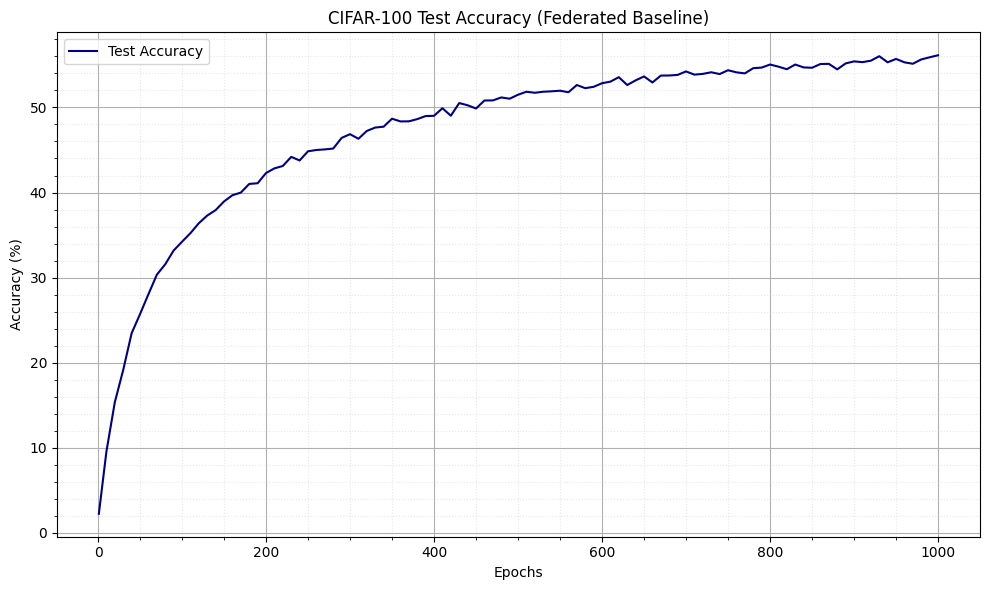

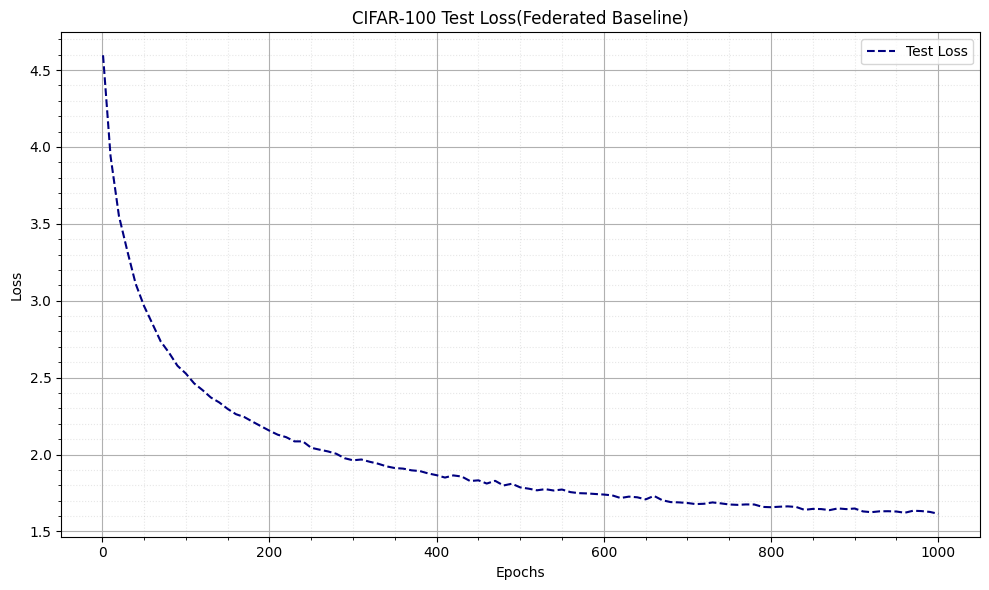

Plots have been saved as 'test_accuracy.pdf' and 'test_loss.pdf'


In [10]:
def plot_fedavg_results(rounds_list, test_accuracies, test_losses):
    import matplotlib.pyplot as plt

    # Use rounds_list directly for the x-axis
    rounds = rounds_list

    # Plot and save Test Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(rounds, test_accuracies, color='navy', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('CIFAR-100 Test Accuracy (Federated Baseline)')
    plt.legend()
    plt.grid(True)
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', alpha=0.3)
    plt.tight_layout()
    plt.savefig('test_accuracy.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

    # Plot and save Test Loss
    plt.figure(figsize=(10, 6))
    plt.plot(rounds, test_losses, color='navy', linestyle='--', label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('CIFAR-100 Test Loss(Federated Baseline)')
    plt.legend()
    plt.grid(True)
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', alpha=0.3)
    plt.tight_layout()
    plt.savefig('test_loss.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

    print("Plots have been saved as 'test_accuracy.pdf' and 'test_loss.pdf'")

# After finishing federated learning and obtaining test_accuracies, test_losses, and rounds_list:
plot_fedavg_results(rounds_list, test_accuracies, test_losses)